In [1]:
%matplotlib inline

In [2]:
import emcee
import autograd.numpy as np
import matplotlib.pyplot as plt
from astropy.stats import LombScargle
from scipy.optimize import minimize

In [3]:
from mcmcrotation import read_file

In [4]:
import celerite
from celerite import terms

In [5]:
celerite.__version__

'0.2.0'

In [6]:
class SmoothRotationTerm(terms.Term):
    parameter_names = ("log_a", "log_b", "log_f", "log_P")

    def get_real_coefficients(self, params):
        log_a, log_b, log_f, log_P = params
        b = np.exp(log_b)
        c = 2*np.pi*np.exp(log_f - log_P) / (2.0 + b)
        return (
            np.exp(log_a) * (1.0 + b) / (2.0 + b), c,
        )

    def get_complex_coefficients(self, params):
        log_a, log_b, log_f, log_P = params
        b = np.exp(log_b)
        c = 2*np.pi*np.exp(log_f - log_P) / (2.0 + b)
        factor = np.exp(log_a) / (2.0 + b)
        return (
            factor, factor * np.exp(log_f),
            c, 2*np.pi*np.exp(-log_P),
        )

In [7]:
data = read_file("../data/215900519P-ep20160806.csv")
mask = np.isfinite(data.flux) & (~data.bgmask) & (~data.fmask) & (~data.thrustermask) & (~data.fdtmask)
data = data[mask]
t, y, yerr = np.array(data.time), np.array(data.flux), np.array(data.ferr)

# Do some aggressive sigma clipping
m = np.ones(len(t), dtype=bool)
while True:
    mu = np.mean(y[m])
    sig = np.std(y[m])
    m0 = np.abs(y - mu) < 3 * sig
    if np.all(m0 == m):
        break
    m = m0

t, y, yerr = t[m], y[m], yerr[m]

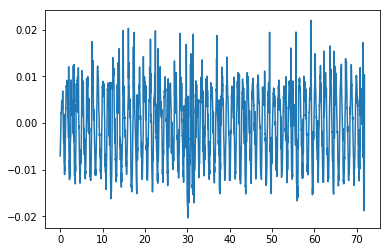

In [8]:
plt.plot(t, y)

(0, 10)

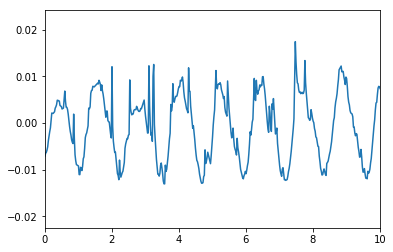

In [9]:
plt.plot(t, y)
plt.xlim(0, 10)

1.22117451632


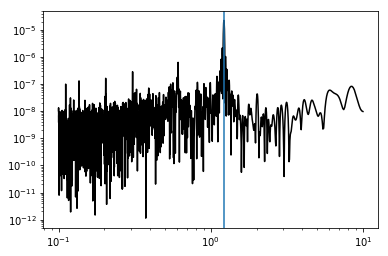

In [10]:
# First guess at the period
freq = np.linspace(0.1, 10.0, 5000)
model = LombScargle(t, y)
power = model.power(freq, method="fast", normalization="psd")
power /= len(t)

period = 1.0 / freq[np.argmax(power)]
print(period)

plt.plot(1.0 / freq, power, "k")
plt.axvline(period)
plt.xscale("log")
plt.yscale("log")

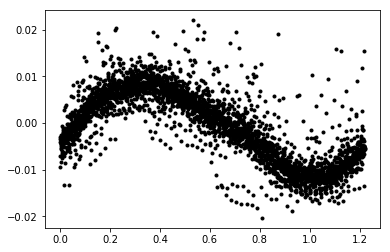

In [11]:
plt.plot(t % period, y, ".k")

In [15]:
kernel = SmoothRotationTerm(
    log_a=np.log(np.var(y)),
    log_b=-0.1,
    log_f=-1.0,
    log_P=np.log(period),
    bounds=dict(
        log_a=np.log(np.var(y) * np.array([0.001, 10.0])),
        log_b=(-15.0, 0.0),
        log_f=(-15.0, 0.0),
        log_P=np.log(period * np.array([0.5, 2.0])),
    ),
)
kernel += terms.SHOTerm(
    log_S0=np.log(np.var(y)), log_omega0=0.0, log_Q=-0.5*np.log(2.0),
    bounds=dict(
        log_S0=np.log(np.var(y) * np.array([0.001, 10.0])),
        log_omega0=(-15.0, 5.0),
        log_Q=(None, None),
    ))
kernel.terms[1].freeze_parameter("log_Q")
kernel += terms.JitterTerm(log_sigma=np.log(np.median(np.abs(np.diff(y)))),
                           bounds=[(-10, 0.0)])

gp = celerite.GP(kernel)

initial_params = gp.get_parameter_vector()

gp.compute(t, yerr)
gp.log_likelihood(y)

7703.223502330427

In [20]:
def neg_log_like(params, y, gp, m):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y[m])

def grad_neg_log_like(params, y, gp, m):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y[m])[1]

# Do another round of sigma clipping using the GP model
bounds = gp.get_parameter_bounds()
m = np.ones(len(t), dtype=bool)
for i in range(10):
    gp.compute(t[m], yerr[m])
    soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                    method="L-BFGS-B", bounds=bounds, args=(y, gp, m))
    gp.set_parameter_vector(soln.x)
    print(soln)
    initial_params = soln.x
    mu, var = gp.predict(y[m], t, return_var=True)
    sig = np.sqrt(var + yerr**2)
    
    m0 = np.abs(y - mu) < 3 * sig
    print(m0.sum(), m.sum())
    if np.all(m0 == m) or (np.abs(m0.sum()- m.sum()) < 3):
        break
    m = m0
    
fit_t, fit_y, fit_yerr = t[m], y[m], yerr[m]

gp.compute(fit_t, fit_yerr)
gp.log_likelihood(fit_y)   
gp.get_parameter_dict()

      fun: -14625.440881464785
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.0296016 ,  0.16947314, -0.020518  ,  0.08179882,  0.00234435,
       -0.1054483 ,  0.00159229])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 81
      nit: 57
   status: 0
  success: True
        x: array([ -9.68423526,  -2.39006789,  -7.34992847,   0.19851619,
       -14.39407296,   3.37533302,  -6.60621628])
3132 3200
      fun: -15405.016036097451
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.25126339,  0.10516337, -0.28699658,  0.10073333, -0.18791013,
       -0.64928811, -0.20258449])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 29
      nit: 25
   status: 0
  success: True
        x: array([ -9.68795159,  -2.39148687,  -7.3531762 ,   0.19861641,
       -14.42846535,   3.30136339,  -7.35647782])
3137 3132
      fun: -15493.723014323255
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>

OrderedDict([('kernel:terms[0]:log_a', -9.6856002082959396),
             ('kernel:terms[0]:log_b', -2.3923405532007749),
             ('kernel:terms[0]:log_f', -7.3504649983223871),
             ('kernel:terms[0]:log_P', 0.19862637270915126),
             ('kernel:terms[1]:log_S0', -14.44072487121354),
             ('kernel:terms[1]:log_omega0', 3.3155220418626876),
             ('kernel:terms[2]:log_sigma', -7.460850942557526)])

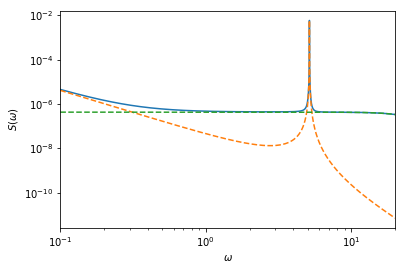

In [22]:
omega = np.exp(np.linspace(np.log(0.1), np.log(20), 5000))
psd = gp.kernel.get_psd(omega)

plt.plot(omega, psd)
for k in gp.kernel.terms:
    plt.plot(omega, k.get_psd(omega), "--")

plt.yscale("log")
plt.xscale("log")
plt.xlim(omega[0], omega[-1])
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");

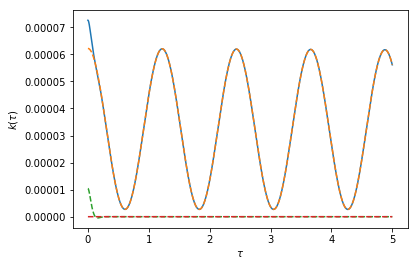

In [23]:
tau = np.linspace(0, 5, 5000)
plt.plot(tau, gp.kernel.get_value(tau))
for k in gp.kernel.terms:
    plt.plot(tau, k.get_value(tau), "--")
plt.ylabel(r"$k(\tau)$")
plt.xlabel(r"$\tau$")

(0, 30)

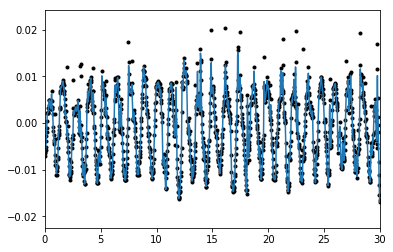

In [24]:
plt.plot(t, y, ".k")
plt.plot(t, gp.predict(fit_y, t, return_cov=False))
plt.xlim(0, 30)

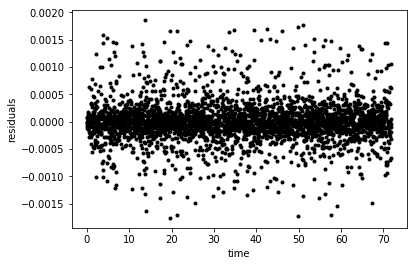

In [25]:
plt.plot(fit_t, fit_y - gp.predict(fit_y, fit_t, return_cov=False), ".k")
plt.ylabel("residuals")
plt.xlabel("time");

In [ ]:
def log_prob(params):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    return lp + gp.log_likelihood(fit_y)

ndim = len(soln.x)
nwalkers = 32
pos = soln.x + 1e-5 * np.random.randn(nwalkers, ndim)
lp = np.array(list(map(log_prob, pos)))
m = ~np.isfinite(lp)
while np.any(m):
    pos[m] = soln.x + 1e-5 * np.random.randn(m.sum(), ndim)
    lp[m] = np.array(list(map(log_prob, pos[m])))
    m = ~np.isfinite(lp)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
pos, _, _ = sampler.run_mcmc(pos, 500)
sampler.reset()
sampler.run_mcmc(pos, 1000);

In [ ]:
plt.plot(np.exp(sampler.chain[:, :, 3].T), alpha=0.3);

In [ ]:
plt.hist(np.exp(sampler.flatchain[:, 3]), 100, histtype="step");

In [ ]:
import corner
corner.corner(sampler.flatchain);